In [1]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

sys.path.append(r"C:\Users\pgrover\Documents\code\pymorph")
import weno_morph_model as wmm
import schemes.weno as weno
import numpy as np
from scipy.signal import savgol_filter
import sediment_transport.sed_trans as st
%load_ext cython
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('classic')

# Simple Morphodynamic Modelling for Paper 2 - Queens Flume Study

In [2]:
geometry_folder = r'C:\Users\pgrover\Dropbox\PhD\Papers\Paper 2 - Roughness Turbulence LRN\FlumeExperiment\geometries'
bed_filepath = os.path.join(geometry_folder, 'flume_profile_smoothed_v002.txt')


D50 = 1.0/1000.
model = wmm.UpwindMorphologicalModel(D50)
zbed, xc, dx = wmm.load_bed_profile(bed_filepath)

['ncols', '4']
['nrows', '87']
['xllcorner', '0']
['yllcorner', '0']
['cellsize', '0.03']
['NODATA_value', '-9999']


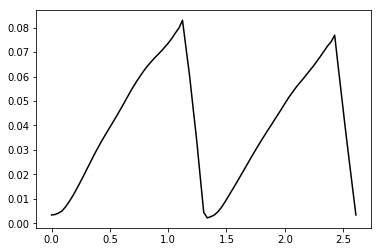

In [3]:
plt.plot(xc,zbed,'k-')

## Re-interpolate the profile

In [4]:
case_folder = r'C:\Data\PhD\LRN-WallTreatments-openFOAM-5.x\validation\QueensFlume'

bed_shear_filepath = os.path.join(case_folder,'32.cm', 'dune.127z.30r.colebrook.yp.0.x', '30', 'wallShearStress.txt')
bed_shear_stress = wmm.load_bed_shear_stress(bed_shear_filepath)


In [5]:
dune_length=xc.max()
xint = np.linspace(0, dune_length, len(bed_shear_stress))
zinterp = np.interp(xint, xc,zbed)




No handles with labels found to put in legend.


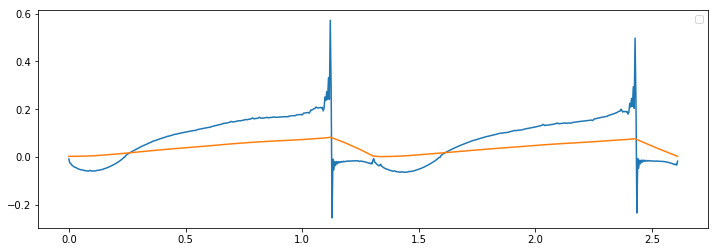

In [6]:
plt.figure(figsize=[12,4.])
#plt.style.use('dark_background')
#plt.style.use('classic')
plt.plot(xint,bed_shear_stress*-100.)
plt.plot(xc, zbed)
plt.legend()

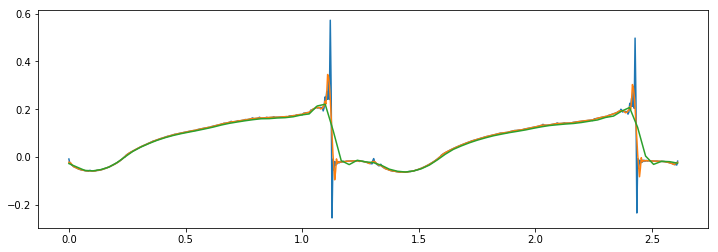

In [7]:
import scipy.signal

plt.figure(figsize=[12,4.])
bed_shear_stress_smoothed_7 = savgol_filter(bed_shear_stress, 7, 2, mode='wrap')
bed_shear_stress_smoothed_11 = savgol_filter(bed_shear_stress, 11, 2, mode='wrap')
bed_shear_stress_smoothed_21 = savgol_filter(bed_shear_stress, 21, 2, mode='wrap')
bed_shear_stress_smoothed_31 = savgol_filter(bed_shear_stress, 31, 2, mode='wrap')

bed_shear_stress_decimated=scipy.signal.decimate(bed_shear_stress,3, ftype="iir")
bed_shear_stress_decimated = savgol_filter(bed_shear_stress_decimated, 13, 3, mode='wrap') 
bed_shear_stress_decimated=scipy.signal.decimate(bed_shear_stress_decimated,3, ftype="iir")

xdec = np.linspace(0, dune_length, len(bed_shear_stress_decimated))
zinterpdec = np.interp(xdec, xc,zbed)


# bed_shear_stress_smoothed_31 = savgol_filter(bed_shear_stress_smoothed_31,41, 2, mode='wrap')

plt.plot(xint,bed_shear_stress*-100.)
plt.plot(xint,bed_shear_stress_smoothed_11*-100.)
#plt.plot(xint,bed_shear_stress_smoothed_21*-100.)
#plt.plot(xint,bed_shear_stress_smoothed_31*-100.)
plt.plot(xdec,bed_shear_stress_decimated*-100.)


## Looking into second derivative

This seems to be where we run into problems - when the second order derivative is positive - moving upwards. 

(1.0, 1.5)

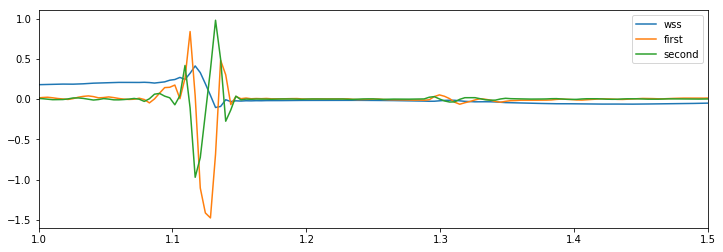

In [8]:
bss = np.array(bed_shear_stress_smoothed_7*-100.)

dtaudx = np.gradient(bss)
d2taudx2 = np.gradient(dtaudx)

plt.figure(figsize=[12,4.])
plt.plot(xint,bss, label='wss')
plt.plot(xint,dtaudx*10., label='first')
plt.plot(xint,d2taudx2*10., label='second')
plt.legend()
plt.xlim([1.0, 1.5])

 Starting simulation....
Number of time steps: 8
Grid dx = 0.003799126637554585
Grid nx = 688
Max Shear Stress:    5.72415
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max Shear Stress:    2.0274285887650034
qbedload shape: (688,)
Max qbedload = 1.9847971036152767e-05
 Done
 ----------------------------


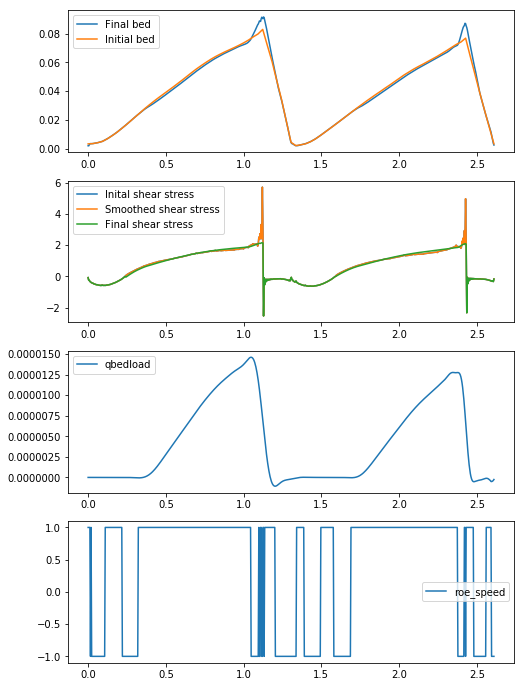

In [24]:
model = wmm.UpwindMorphologicalModel(D50)

#dx = xdec[1]-xdec[0]
#bed_shear_stress_init = bed_shear_stress_decimated.copy() * -1000.

bed_shear_stress_init = bed_shear_stress.copy() * -1000.
dx=xint[1]-xint[0]

model.setup_model(bed_shear_stress_init, zinterp.copy(), xint, dx, useSmoother=True, adjustment_angle=28.)
simulationTime = 40
dt = 5

zc, qbedload, bedShear, roe_speed = model.run_model(simulationTime, 
                                                             dt=dt, 
                                                             useSlopeAdjust=True)

fig, axs = plt.subplots(4,1, figsize=[8,12])
axs[0].plot(xint, zc, label='Final bed')
axs[0].plot(xc, zbed, label='Initial bed')
#axs[0].set_xlim([0.075, 0.125])
axs[0].legend(prop=None)

axs[1].plot(xint, bed_shear_stress*-1000., label='Inital shear stress')
axs[1].plot(xint, bed_shear_stress_init, label='Smoothed shear stress')
axs[1].plot(xint, bedShear, label='Final shear stress')
#axs[1].set_xlim([0.075, 0.125])
axs[1].legend()

axs[2].plot(xint, qbedload, label='qbedload')
axs[2].legend()

axs[3].plot(xint, roe_speed, label='roe_speed')
axs[3].legend()

In [10]:
bed_shear_stress_init

array([-7.91000e-02, -2.44221e-01, -2.54989e-01, -3.25577e-01,
       -3.47179e-01, -3.88181e-01, -4.08956e-01, -4.27112e-01,
       -4.31710e-01, -4.65226e-01, -4.78142e-01, -4.97615e-01,
       -5.09436e-01, -5.21973e-01, -5.33349e-01, -5.34827e-01,
       -5.36058e-01, -5.54826e-01, -5.62206e-01, -5.68640e-01,
       -5.75522e-01, -5.76453e-01, -5.85729e-01, -5.63883e-01,
       -5.52348e-01, -5.77168e-01, -5.78239e-01, -5.82169e-01,
       -5.80531e-01, -5.77902e-01, -5.75600e-01, -5.62019e-01,
       -5.50023e-01, -5.55516e-01, -5.47786e-01, -5.42043e-01,
       -5.32388e-01, -5.22938e-01, -5.12160e-01, -4.97892e-01,
       -4.82253e-01, -4.74564e-01, -4.60176e-01, -4.46863e-01,
       -4.31133e-01, -4.15357e-01, -3.98916e-01, -3.79168e-01,
       -3.59616e-01, -3.45432e-01, -3.26330e-01, -3.06950e-01,
       -2.86052e-01, -2.64860e-01, -2.42395e-01, -2.19281e-01,
       -1.95169e-01, -1.70631e-01, -1.44185e-01, -1.16452e-01,
       -8.60000e-02, -5.38000e-02, -7.15000e-03, -6.160

## Fitting Methodology

The idea here is to develop a curve which fits the general relationship between the depth of flow and the shear stress

In [11]:
import pandas as pd

df = pd.DataFrame(
    {
        'zbed':zinterp,
        'tau':bed_shear_stress_init
    })
dfclean = df[df.tau>0.]

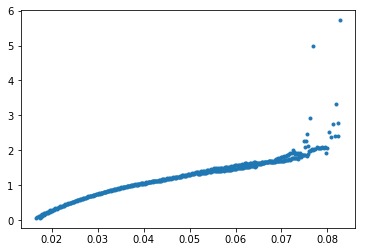

In [12]:
plt.plot(dfclean.zbed, dfclean.tau,'.')

In [13]:
from scipy import optimize
import math

def test_func(x, a, b):
    return a*np.log10(x) + b

params, params_covariance = optimize.curve_fit(test_func, dfclean.zbed.tolist(), dfclean.tau.tolist(), p0=[2.,2.])

print(params)

[2.96591299 5.23689584]


In [14]:
x_test = np.linspace(0.,0.08,30)

y_tests = test_func(x_test,params[0],params[1])


c:\users\pgrover\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


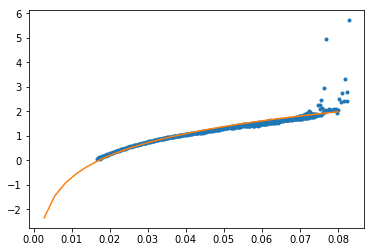

In [15]:
plt.plot(dfclean.zbed, dfclean.tau,'.')
plt.plot(x_test, y_tests,'-')